# Genomics Data Notebook 2: Normalizing Our Data



---

### Goal For This Notebook:

1 - Normalize the data so we can better compare the data, by using a relative scale instead of directly comparing them.<br>

---

### Table of Contents

1 - [What Is Normalization?](#section1)<br>

2 - [Normalization by Read Depth](#section2)<br>

3 - [Checking the Effect of Normalization](#section3)<br>

4 - [Transposing Data](#section4)<br>

5 - [Nomalization by Gene Length](#section5)

---

<img src="images/algae.png" align="left">

In this notebook, we will look at our cleaned data from the previous notebook and then normalize the data. Normalization allows us to compare our data on a relative scale instead of directly comparing them. This will allow us to visualize data easier for the next notebook and help us find relationships in the data.

Normalization is a new topic so this notebook will break it down into steps. But first, as always, let us import the needed libraries:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load yesterday's cleaned table into `rna_data`. Recall that we saved yesterday's work into a file called "rna_data_cleaned.csv" in the *data* folder. Double check that `rna_data` is what it looked like yesterday.

*The `index_col=0` argument allows us to set the first column as the index of the dataframe. If you are curious, you can try running the code without the argument and see the difference.*

In [6]:
# EXERCISE

rna_data = pd.read_csv("data/rna_data_cleaned.csv", index_col=0)

rna_data.head()

,0.5HL-0,0.5HL-1,0.5HL-2,0.5HL-3,12HL-0,12HL-1,12HL-2,12HL-3,1HL-0,1HL-1,...,1ML-2,1ML-3,3ML-0,3ML-1,3ML-2,3ML-3,6ML-0,6ML-1,6ML-2,6ML-3
tracking_id,,,,,,,,,,,,,,,,,,,,,
Cz01g00020,657,534,710,501,332,348,300,413,316,394,...,590,667,460,463,524,458,296,285,272,110
Cz01g00030,255,303,257,244,154,140,147,144,210,201,...,224,302,199,243,215,235,182,184,160,47
Cz01g00040,90,71,94,87,149,204,150,220,36,56,...,81,67,81,78,84,89,129,98,115,57
Cz01g00050,49,46,73,42,134,169,145,155,23,21,...,53,65,69,63,67,61,99,86,69,38
Cz01g00060,36,33,51,39,46,52,38,44,20,26,...,37,54,31,20,31,22,47,38,29,19


## 1. What Is Normalization?<a id='section1'>

Previously, we noted that the values in a single column ranged from 0 to the hundreds of thousands. Since it is hard to look at numbers in this wide of a range, we want to "normalize" the data. Normalizing data means that we adjust the scale of our data by comparing our numbers on a relative scale instead of directly comparing them. This helps with data that takes on a large range of numbers, and it eliminates the issue of comparing categories that are on different scales.

For example, let's say we have two classes, Class 1 and Class 2, with class sizes of 10 and 1,000 respectively. If 10 students from each class earn a perfect score on a test, we can tell that there is a significant difference between Class 1 and Class 2's performances. However, both classes had the same number of perfect test scores when we look at the raw numbers. In order to better portray this, we want to work with relative numbers.

Let's see how this would look with the data table `classes`.

In [7]:
# EXAMPLE

classes = pd.DataFrame([["A", 10, 10], ["B", 0, 900], ["C", 0, 90]], 
                       columns=["Grade", "Class 1", "Class 2"])
classes = classes.set_index("Grade")
classes

,Class 1,Class 2
Grade,,
A,10,10
B,0,900
C,0,90


If we were to only look at the data associated with "A" grades, we would not know that Class 1 is performing better than Class 2. Instead, we see that both classes had the same number of scores.

In [8]:
# EXAMPLE

classes.loc["A"]

Class 1    10
Class 2    10
Name: A, dtype: int64

In order to normalize the data, we could divide our `Class 1` data by the total number of students in `Class 1` and our `Class 2` data by the total number of students in `Class 2`. This tells us what **proportion** of students received a perfect score instead of what **number** of students did.

In [9]:
# EXAMPLE

num_students_1 = sum(classes.iloc[:, 0]) #taking the sum of column 0, Class 1
num_students_2 = sum(classes.iloc[:, 1]) #taking the sum of column 1, Class 2

classes["Class 1"] = classes["Class 1"]/num_students_1 #Divide Class 1 data by the total number of students in Class 1
classes["Class 2"] = classes["Class 2"]/num_students_2 #Divide Class 2 data by the total number of students in Class 2

print("# of students in Class 1: " + str(num_students_1))
print("# of students in Class 2: " + str(num_students_2))

classes

# of students in Class 1: 10
# of students in Class 2: 1000


,Class 1,Class 2
Grade,,
A,1.0,0.01
B,0.0,0.90
C,0.0,0.09


Now, if we only look at the data associated with "A" grades, we can see the difference between Class 1 scores and Class 2 scores.

In [10]:
# EXAMPLE

classes.loc["A"]

Class 1    1.00
Class 2    0.01
Name: A, dtype: float64

## 2. Normalization By Read Depth <a id='section2'>

Let's apply this logic to our genomics data. Here, our columns are experiment conditions, and our rows are specific genes. It is possible that a condition has the fewest counts for all genes because the sample actually "turns on" fewer genes than other conditions, but it is also possible that the condition had fewer counts overall. In order to analyze this, we need to find out how many counts were obtained across all genes under a specific condition.

Let's define what we will be working with.
- **reads:** the # of genes that "turned on" (ie. the values in our data)
- **read depth:** the total # of reads across *all* genes under a specific condition

**Consider this oversimplification of our `rna_data` table.** For fictional gene Cz1, we see that high light (HL) conditions produce more reads than medium light (ML) conditions. However, when compared to other genes, we notice that the relative reads are larger under the `ML` condition than under the `HL` condition.

In [11]:
# EXAMPLE

simple_rna = pd.DataFrame([["Cz1", 50, 20], ["Cz2", 100, 1], ["Cz3", 100, 1]], 
                       columns=["Gene", "HL", "ML"])
simple_rna = simple_rna.set_index("Gene")
simple_rna

,HL,ML
Gene,,
Cz1,50,20
Cz2,100,1
Cz3,100,1


Let's write some code that calculates the read depths of all experiment conditions/samples.

- Create an empty list of read depths called `read_depths`.
- Create a for loop (see notebook 04) that goes through each experiment condition (i.e. each sample):
    - Calculate the read depth by finding the total number of reads across all genes in one column. Store it in the variable `one_read_depth`.
    - Add the variable `one_read_depth` to our list, `read_depths`.
    
Looking back at the classes example earlier, this is synonymous to calculating all of our class sizes.

In [12]:
# EXERCISE

read_depths = []
num_samples = len(rna_data.columns)

for i in range(num_samples):
    one_read_depth = sum(rna_data.iloc[:, i])
    read_depths.append(one_read_depth)

print("These are the read depths of all samples:")
print(read_depths)

These are the read depths of all samples:
[7049388, 7703469, 7610909, 6755036, 4854744, 5191732, 4239524, 5599366, 5635954, 5263859, 6532152, 4913977, 5978414, 5288713, 4910881, 5371061, 3808098, 1320667, 2260677, 4224192, 5734265, 5314042, 5720182, 5275529, 5453292, 867058, 7349108, 5271695, 5876465, 6314524, 5414810, 5750348, 5450678, 6811563, 6368474, 7878534, 5353554, 5119009, 4798766, 5427228, 5607847, 5056234, 4724507, 2027099]


Now make a scatter plot (see notebook 08) that shows the range of read depths across all samples. 

We want the x-axis to be the different samples (i.e. the column labels) and the y-axis to be the read depths corresponding to those samples.

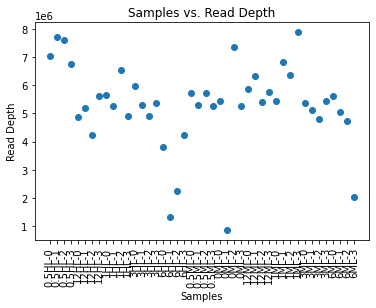

In [13]:
# EXERCISE

x_data = rna_data.columns
y_data = read_depths

plt.scatter(x_data, y_data)
plt.title("Samples vs. Read Depth")
plt.xlabel("Samples")
plt.ylabel("Read Depth")
plt.xticks(rotation=90);

Through this visualization, you can see that the read depth differs by a large amount under different conditions and samples. This is like how our class sizes differed, so it is a good thing that we have decided to normalize our data!

Now let's create a function (see notebook 01) that normalizes the data in our `rna_data` table. Write some code that calculates relative reads based on read depths. 

For reference, we have provided the normalization of our example dataframe `simple_rna` by read depth below. You can see that to normalize our data, we divide the dataframe by the list `simple_read_depths`, which contain the read depths (the total # of gene counts) for each column.

In [14]:
# EXAMPLE

simple_read_depths = [250, 22]

simple_rna_by_read_depth = simple_rna / simple_read_depths
simple_rna_by_read_depth

,HL,ML
Gene,,
Cz1,0.2,0.909091
Cz2,0.4,0.045455
Cz3,0.4,0.045455


In [15]:
# EXERCISE

def normalizeByReadDepth(data, read_depth_list):
    return data / read_depth_list

Now that we have a function that normalizes by read depth (the total # of gene counts), we can normalize `rna_data` by read depth. Recall that we calculated the read depths of all experiment conditions/samples and stored it in a list called `read_depths`. Now, use `rna_data` and `read_depths` with our new function to get a normalized data table:

In [16]:
# EXERCISE

rna_by_read_depth = normalizeByReadDepth(rna_data, read_depths)

rna_by_read_depth.head()

,0.5HL-0,0.5HL-1,0.5HL-2,0.5HL-3,12HL-0,12HL-1,12HL-2,12HL-3,1HL-0,1HL-1,...,1ML-2,1ML-3,3ML-0,3ML-1,3ML-2,3ML-3,6ML-0,6ML-1,6ML-2,6ML-3
tracking_id,,,,,,,,,,,,,,,,,,,,,
Cz01g00020,0.000093,0.000069,0.000093,0.000074,0.000068,0.000067,0.000071,0.000074,0.000056,0.000075,...,0.000093,0.000085,0.000086,0.000090,0.000109,0.000084,0.000053,0.000056,0.000058,0.000054
Cz01g00030,0.000036,0.000039,0.000034,0.000036,0.000032,0.000027,0.000035,0.000026,0.000037,0.000038,...,0.000035,0.000038,0.000037,0.000047,0.000045,0.000043,0.000032,0.000036,0.000034,0.000023
Cz01g00040,0.000013,0.000009,0.000012,0.000013,0.000031,0.000039,0.000035,0.000039,0.000006,0.000011,...,0.000013,0.000009,0.000015,0.000015,0.000018,0.000016,0.000023,0.000019,0.000024,0.000028
Cz01g00050,0.000007,0.000006,0.000010,0.000006,0.000028,0.000033,0.000034,0.000028,0.000004,0.000004,...,0.000008,0.000008,0.000013,0.000012,0.000014,0.000011,0.000018,0.000017,0.000015,0.000019
Cz01g00060,0.000005,0.000004,0.000007,0.000006,0.000009,0.000010,0.000009,0.000008,0.000004,0.000005,...,0.000006,0.000007,0.000006,0.000004,0.000006,0.000004,0.000008,0.000008,0.000006,0.000009


Because each value is a proportion, the values under each column should each sum up to 1. Let's verify that.

In [17]:
column_totals = []

for i in range(num_samples): 
    one_column_total = np.round(sum(rna_by_read_depth.iloc[:, i])) 
    column_totals.append(one_column_total)

print("These are sums of all columns:")
print(column_totals)

These are sums of all columns:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Let's visualize our column totals once again. Previously, our column totals were our read depths, because they were the sum of all reads under a certain condition/sample. Now, our data is in relative reads (i.e. proportions), so our column totals should all be lined up at 1.

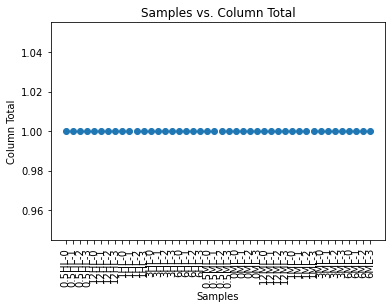

In [18]:
x_data = rna_data.columns
y_data = column_totals

plt.scatter(x_data, y_data)
plt.title("Samples vs. Column Total")
plt.xlabel("Samples")
plt.ylabel("Column Total")
plt.xticks(rotation=90);

Now, our various conditions/samples are all on the same "scale", so it will be easier to compare between different light conditions and samples.

To verify this, let's compare the data for gene `Cz01g00040` before and after normalizating by read depth.

## 3. Checking the Effect of Normalization<a id='section3'>

Create a plot that shows reads for only gene `Cz01g00040` in the dataframe `rna_data`. Each row corresponds to a specific gene, so you will need to access the `Cz01g00040` row in the table (hint: use `loc` - see notebook 07). 

Going back to our classes example, this visualization would be similar to plotting the raw grade counts for the `classes` data (i.e. it will not show the relative differences).

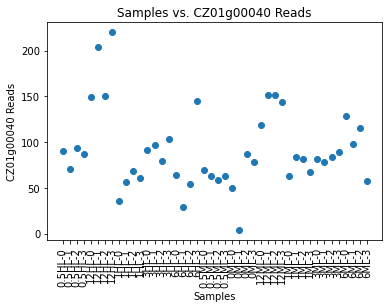

In [19]:
# EXERCISE

x_data = rna_data.columns
y_data = rna_data.loc['Cz01g00040', :]

plt.scatter(x_data, y_data)
plt.title("Samples vs. CZ01g00040 Reads")
plt.xlabel("Samples")
plt.ylabel("CZ01g00040 Reads")
plt.xticks(rotation=90);

**Question 1** What is the scale of `Cz01g00040` reads? How much larger is the highest read compared to the lowest read? Is there a pattern or trend in the visualization?

**Key: Scale is from approximately 0 to close to 250. There doesn't seem to be a clear rend, but data seems to fluctuate up and down going from sample to sample.**

Now let's look at the normalized reads for gene `Cz01g00040` in the normalized dataframe `rna_by_read_depth`. Once again, `Cz01g00040` is a row in our table whose data you need to access using `loc`. This visualization shows the normalized reads of this gene, so it accounts for the total number of reads each condition produced.

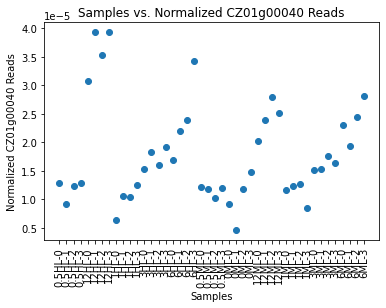

In [20]:
# EXERCISE

x_data = rna_data.columns
y_data = rna_by_read_depth.loc['Cz01g00040', :]

plt.scatter(x_data, y_data)
plt.title("Samples vs. Normalized CZ01g00040 Reads")
plt.xlabel("Samples")
plt.ylabel("Normalized CZ01g00040 Reads")
plt.xticks(rotation=90);

**Question 2** What is the scale of normalized `Cz01g00040` reads? How much larger is the highest read compared to the lowest read? Is there a pattern or trend in the visualization? Did it change from the previous visualization?

**Key: Scale is from 0 to around 4e-5 = 0.00004. There seems to be a clearer pattern than previously.**

Recall that we have normalized the data such that the table's values represent the reads (or gene counts) relative to the total reads (or read depth) based on the corresponding experiment conditions and sample number. As an example, we saw how gene `Cz01g00040`'s data pattern became more clear after normalization.

Even though this made our data easier to analyze, we can still do more normalization to aide the interpretation of our data.

When we normalized by read depth, we normalized by column. More specifically, we took the totals of each column and represented each data value as a proportion of each total. In order to improve our analysis, we can also do normalization by row.

**Question 3** What does each row represent? What characteristics do genes have? What do you think we could do normalization by?

**Key: Each row represents the specific gene. One characteristic of genes is length - we could try normalizing by length.**

## 4. Transposing Data<a id='section4'>

Before we can normalize by row, we need to go over the concept of transposing data. Recall that normalizing by column consisted of dividing our columns by the sum of each column. We did this by dividing the dataframe by a list that contained the column sums. 

Unfortunately, computers can only divide columns by arrays/lists and cannot divide rows by arrays/lists. In order to account for this, we can transpose our data -- flip our data table such that the rows are columns and the columns are rows. After normalizing our columns, we can transpose our data again, so that our columns are back to being rows.

<img src="images/transpose.png" width="500">

*Image credit: w3resource*

Let's first take a look at the `classes` data table that we worked with previously. 

In [21]:
# EXAMPLE

classes = pd.DataFrame([["A", 10, 10], ["B", 0, 900], ["C", 0, 90]], 
                       columns=["Grade", "Class 1", "Class 2"])
classes = classes.set_index("Grade")
classes

,Class 1,Class 2
Grade,,
A,10,10
B,0,900
C,0,90


Try using the function `np.transpose()` so that the `classes` table has the following structure.
- Columns: "Grade", "A", "B", "C"
- Rows: "Class 1", "Class 2"

In [22]:
classes_by_grade = np.transpose(classes)
classes_by_grade

Grade,A,B,C
Class 1,10,0,0
Class 2,10,900,90


Now we can perform normalization just like before. To do this, divide the transposed dataframe by the totals for each grade (A, B, C).

Note that these values should *not* be the same as the normalized values from [section 1](#section1)

In [23]:
# EXERCISE

grade_totals = [20, 900, 90]

classes_by_grade_shares = classes_by_grade / grade_totals
classes_by_grade_shares

Grade,A,B,C
Class 1,0.5,0.0,0.0
Class 2,0.5,1.0,1.0


Now we will apply `np.transpose()` once again and update our `classes` dataframe:

In [24]:
classes = np.transpose(classes_by_grade_shares)

classes

,Class 1,Class 2
Grade,,
A,0.5,0.5
B,0.0,1.0
C,0.0,1.0


Altogether, the whole process (denoted below) normalizes our original table, `classes`, by row.

1. Transpose the table so that the rows are columns and the columns are rows.
2. Do column division by an array/list.
3. Transpose the table again so that the structure is the same as the original table.

## 5. Normalization by Gene Length <a id='section5'>

Now you know how to apply normalization by row. Let's think about *what* we want to normalize by. Each row represents a specific gene, so it might be worthwhile to consider the length of a gene. Different genes have different lengths, so let's check out the lengths of our genes.

In the cell below, load the information we have on each gene via the "gene_info.info" file (located in the data folder). Like the original `rna_data` table, this file is separated by tabs instead of commas. Indicate this in your function call with the argument `sep=...`.

*Hint*: if you forgot what to put in the ellipses (...), check what you did in the first genomics notebook!

In [25]:
# EXERCISE

gene_info = pd.read_csv('data/gene_info.info', sep='\t', index_col=0)

gene_info.head()

,chrom,start,stop,length
geneID,,,,
Cz01g00020,chr01,1227,6754,5527
Cz01g00030,chr01,8009,9332,1323
Cz01g00040,chr01,11759,17522,5763
Cz01g00050,chr01,17768,23386,5618
Cz01g00060,chr01,24364,25508,1144


This data table gives us a lot of interesting information! First, our index is `geneID`, which seems similar to our `tracking_id` column in `rna_data`. The column `chrom` tells us what chromosome the gene can be found on, and the columns `start` and `stop` tell us where the gene begins and ends on that chromosome. Finally, `length` refers to how long that specific gene is.

The last column would be the most useful to us for row normalization. Genes that are of longer lengths may produce more reads than those of shorter lengths, so we need to take that into account. Let's normalize the dataframe `rna_by_read_depth` by each row's gene length.

First though we have to check whether or not the gene IDs of `gene_info` are in the same order as the gene IDs in `rna_by_read_depth`. Do this in the next cell and keep in mind that the gene IDs of both data tables are the table indices.

1. Get the indices of both tables (by using `.index`) and assign them them to `gene_info_ids` and `rna_data_ids`.
2. Compare the gene ID arrays using a boolean statement.
3. Count how many indices match up.
    - Recall that 'True' = 1 and 'False' = 0. You can use the `sum()` function.
4. Verify that the number of matching gene IDs is the number of genes in the `rna_by_read_depth` table.

In [26]:
# EXERCISE

gene_info_ids = gene_info.index
rna_data_ids = rna_by_read_depth.index

matches = (gene_info_ids == rna_data_ids)
num_matches = sum(matches)

rna_data_num_rows = len(rna_by_read_depth)
same_order = (num_matches == rna_data_num_rows)

print("The gene IDs are in the same order as the tracking IDs: " + str(same_order))

The gene IDs are in the same order as the tracking IDs: True


Based on the above statement, we can see that the gene ID columns are in the same order for `gene_info` and `rna_by_read_depth`. This means we can take the `length` information from `gene_info` with full confidence that it will be in the same order as the corresponding genes in `rna_data`. 

Let's store that in the variable `gene_lengths` in the next cell:

In [27]:
# EXERCISE

gene_lengths = gene_info["length"]

Let's take a quick peek at the gene lengths of the first 100 genes!

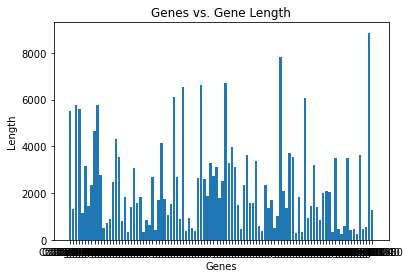

In [28]:
x_data = rna_by_read_depth.index[0:100]
y_data = gene_lengths[0:100]

plt.bar(x_data, y_data)
plt.title("Genes vs. Gene Length")
plt.xlabel("Genes")
plt.ylabel("Length");

Wow! Gene lengths vary by a lot, and these are only the first 100 gene lengths! Once again, it is a good thing we have decided to normalize our data to account for this variability in gene lengths. 

Let's create a function to normalizes `rna_by_read_depth` by rows. Looking back at [section 4](#section4), recall the steps are as follows:
1. Transpose the table so that the rows are columns and the columns are rows.
2. Do column division by an array/list.
3. Transpose the table again so that the structure is the same as the original table.

In [29]:
# EXERCISE

def normalizeByGene(data, gene_length_list):
    transposed_data = np.transpose(data)
    transposed_data_normalized = transposed_data / gene_length_list
    return np.transpose(transposed_data_normalized)
    
    #An one line solution is possible too!
    #return np.transpose(np.transpose(data)/gene_length_list)

Well done! We now have a function that normalizes by row and an array of values that we would like to normalize by. In the next cell, let's normalize `rna_by_read_depth` by `gene_lengths`. 

You might notice that the numbers are incredibly small. Recall that these values are gene reads as proportions of their gene lengths as well as gene reads as proportions of all samples' total reads. 

In [30]:
# EXERCISE

rna_by_gene_len = normalizeByGene(rna_by_read_depth, gene_lengths)
rna_by_gene_len.head()

,0.5HL-0,0.5HL-1,0.5HL-2,0.5HL-3,12HL-0,12HL-1,12HL-2,12HL-3,1HL-0,1HL-1,...,1ML-2,1ML-3,3ML-0,3ML-1,3ML-2,3ML-3,6ML-0,6ML-1,6ML-2,6ML-3
tracking_id,,,,,,,,,,,,,,,,,,,,,
Cz01g00020,1.686260e-08,1.254196e-08,1.687844e-08,1.341901e-08,1.237321e-08,1.212767e-08,1.280309e-08,1.334510e-08,1.014449e-08,1.354261e-08,...,1.676205e-08,1.531761e-08,1.554627e-08,1.636461e-08,1.975660e-08,1.526856e-08,9.550060e-09,1.019831e-08,1.041653e-08,9.818118e-09
Cz01g00030,2.734191e-08,2.973011e-08,2.552330e-08,2.730249e-08,2.397698e-08,2.038243e-08,2.620839e-08,1.943855e-08,2.816385e-08,2.886237e-08,...,2.658599e-08,2.897355e-08,2.809642e-08,3.588067e-08,3.386484e-08,3.272879e-08,2.453101e-08,2.750621e-08,2.559786e-08,1.752520e-08
Cz01g00040,2.215351e-09,1.599276e-09,2.143101e-09,2.234822e-09,5.325634e-09,6.818193e-09,6.139395e-09,6.817658e-09,1.108374e-09,1.846015e-09,...,2.206993e-09,1.475641e-09,2.625392e-09,2.643992e-09,3.037394e-09,2.845531e-09,3.991581e-09,3.363181e-09,4.223697e-09,4.879230e-09
Cz01g00050,1.237266e-09,1.062894e-09,1.707279e-09,1.106725e-09,4.913113e-09,5.794190e-09,6.087923e-09,4.927324e-09,7.264047e-10,7.101226e-10,...,1.481354e-09,1.468541e-09,2.294168e-09,2.190650e-09,2.485212e-09,2.000645e-09,3.142370e-09,3.027538e-09,2.599626e-09,3.336775e-09
Cz01g00060,4.464009e-09,3.744567e-09,5.857437e-09,5.046740e-09,8.282577e-09,8.755179e-09,7.835027e-09,6.868910e-09,3.101962e-09,4.317607e-09,...,5.078557e-09,5.991317e-09,5.061666e-09,3.415215e-09,5.646848e-09,3.543387e-09,7.326148e-09,6.569471e-09,5.365565e-09,8.193182e-09


### What effect did normalization have?

Let's see how our data changed for gene `Cz01g00040` after normalizing the data by gene lengths.

Once again, let's create a plot that visualizes the normalized reads for `Cz01g00040` in `rna_by_read_depth`. Remember that `rna_by_read_depth` is our data normalized by read depths *only*.

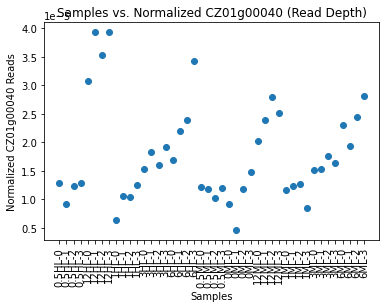

In [31]:
x_data = rna_by_read_depth.columns
y_data = rna_by_read_depth.loc["Cz01g00040", :]

plt.scatter(x_data, y_data)
plt.title("Samples vs. Normalized CZ01g00040 (Read Depth)")
plt.xlabel("Samples")
plt.ylabel("Normalized CZ01g00040 Reads")
plt.xticks(rotation=90);

In this next cell, you should visualize the normalized reads for `Cz01g00040` in `rna_by_gene_len`. This is the data from the previous visualization normalized by gene lengths. 

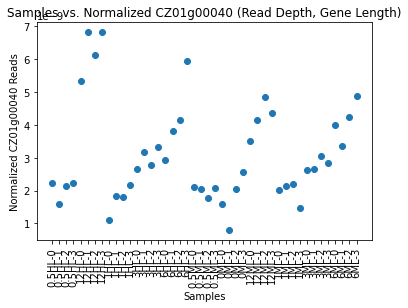

In [32]:
# EXERCISE

x_data = rna_by_gene_len.columns
y_data = rna_by_gene_len.loc["Cz01g00040", :]

plt.scatter(x_data, y_data)
plt.title("Samples vs. Normalized CZ01g00040 (Read Depth, Gene Length)")
plt.xlabel("Samples")
plt.ylabel("Normalized CZ01g00040 Reads")
plt.xticks(rotation=90);

**Question 1** How did the visualization change after the data was normalized by gene length? Did the pattern change? Did the scale of normalized `Cz01g00040` reads change? How much larger is the highest read compared to the lowest read?

**Key: The pattern did not change, the scale did change. When the data was only normalized by read depth, the scale was from 0 to 4e-5, but when the data is normalized by read depth AND gene length, the scale is from 0 to 7e-9 (these are tiny numbers!)**

**Question 2** The changes that occurred may not seem too drastic in the visualization. However, they are still important. Why might that be? *Hint: Look back at your genes vs. gene length graph*

**Key: The variation in gene lengths (as seen in the genes vs. gene length graph) is still very high so it is still important to normalize.**

To finish off this notebook, let's save our progress by using the `.to_csv()` function to save the dataframe `rna_by_gene_len`, as "rna_normalized.csv" in the data folder.

In [33]:
# EXERCISE

rna_by_gene_len.to_csv("data/rna_normalized.csv")

Notebook developed by: Sharon Greenblum, Ciara Acosta, Kseniya Usovich, Alisa Bettale